Logistic regression models the log-odds of an event as a linear combination of one or more independent variables. It is suitable in place of linear regression for binary classification tasks, as its output is bounded between 0 and 1, unlike simple linear regression.

In [1]:
 # import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import training set
train = pd.read_csv('/Users/alessia/Desktop/churn/trans.csv')

In [3]:
print(train.head(10))

   id  CustomerId         Surname  CreditScore  Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668       0  33.0       3   
1   1    15749177   Okwudiliolisa          627       0  33.0       1   
2   2    15694510           Hsueh          678       0  40.0      10   
3   3    15741417             Kao          581       0  34.0       2   
4   4    15766172       Chiemenam          716       0  33.0       5   
5   5    15771669        Genovese          588       0  36.0       4   
6   6    15692819          Ch'ang          593       1  30.0       8   
7   7    15669611     Chukwuebuka          678       0  37.0       1   
8   8    15691707           Manna          676       0  43.0       4   
9   9    15591721        Cattaneo          583       0  40.0       4   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0   

In [4]:
# only select the non-transformed predictor variables
X = train[['CreditScore', 'Age', 'EstimatedSalary', 'Balance', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'France', 'Germany']]
y = train['Exited']

We split the training and test set, through a 75/25 split.

In [5]:
# split training and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [6]:
# save the split as csv
X_train.to_csv(r"/Users/alessia/Desktop/churn/X_train.csv", index=False)
X_test.to_csv(r"/Users/alessia/Desktop/churn/X_test.csv", index=False)
y_train.to_csv(r"/Users/alessia/Desktop/churn/y_train.csv", index=False)
y_test.to_csv(r"/Users/alessia/Desktop/churn/y_test.csv", index=False)

In [7]:
# hyperparameter tuning using gridsearch
Power = range(-12, 10)
C_values = []
for power in Power:
    C_values.append(2**power)

param_grid = {'C': C_values, 'solver': ['liblinear']} 
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=10)
grid_search_lr.fit(X_train, np.ravel(y_train))

# get the best estimator and its parameters
optimal_model = grid_search_lr.best_estimator_
best_params = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

print("Logistic Regression:")
print("Best Score (AUC): {:.4f}".format(best_score))
print("Optimal value for parameter C is:", best_params['C'])

Logistic Regression:
Best Score (AUC): 0.7224
Optimal value for parameter C is: 512


In [8]:
# performance parameters

# predict on the training set
y_pred_train_lr = optimal_model.predict(X_train)
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
print(f"Accuracy on training set: {accuracy_train_lr:.4f}")

# AUC on the training set
y_probs_train_lr = optimal_model.predict_proba(X_train)[:, 1]
fpr_train_lr, tpr_train_lr, _ = roc_curve(y_train, y_probs_train_lr)
roc_auc_train_lr = auc(fpr_train_lr, tpr_train_lr)
print('AUC on training set: {:.4f}'.format(roc_auc_train_lr))

# predict on the test set
y_pred_test_lr = optimal_model.predict(X_test)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)
print(f"Accuracy on test set: {accuracy_test_lr:.4f}")

# AUC on the test set
y_probs_test_lr = optimal_model.predict_proba(X_test)[:, 1]
fpr_test_lr, tpr_test_lr, _ = roc_curve(y_test, y_probs_test_lr)
roc_auc_test_lr = auc(fpr_test_lr, tpr_test_lr)
print('AUC on test set: {:.4f}'.format(roc_auc_test_lr))

Accuracy on training set: 0.7868
AUC on training set: 0.7132
Accuracy on test set: 0.7886
AUC on test set: 0.7116


As expected, the accuracy is higher than the AUC, due to the unbalanced classes in the response variable. We now plot the confusion matrix and the ROC curve.

In [9]:
# confusion matrix
classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Oranges', fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

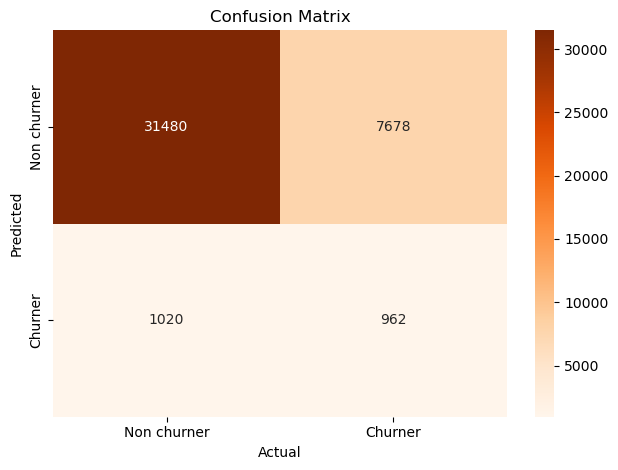

In [10]:
# confusion matrix
plot_confusionmatrix(y_pred_test_lr,y_test)

As we can see by the confusion matrix, logistic regression indeed predicts many customers as churners, since the response classes are unbalanced.

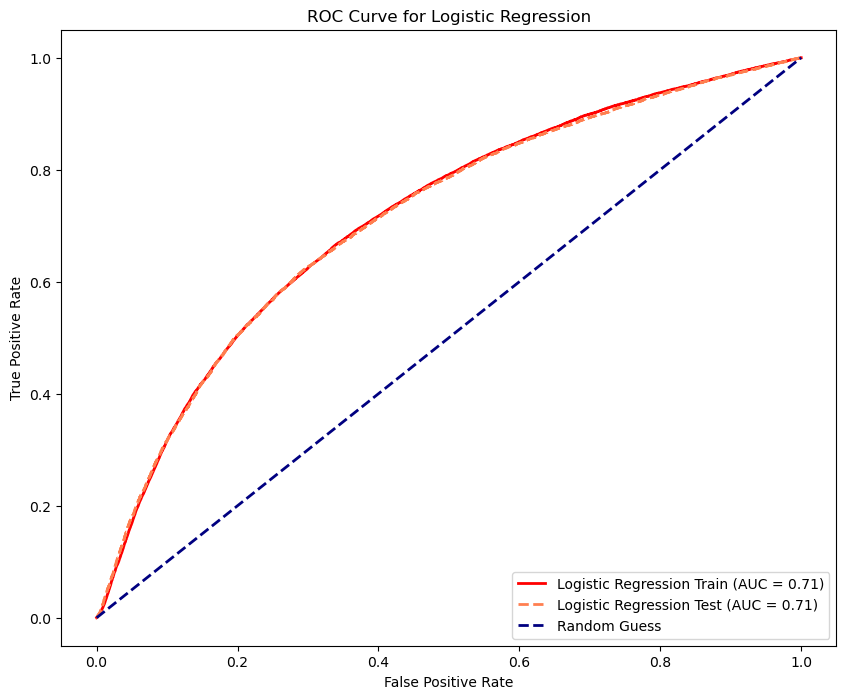

In [11]:
# ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train_lr, tpr_train_lr, color='red', lw=2, label=f'Logistic Regression Train (AUC = {roc_auc_train_lr:.2f})')
plt.plot(fpr_test_lr, tpr_test_lr, color='coral', lw=2, linestyle='--', label=f'Logistic Regression Test (AUC = {roc_auc_test_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

The ROC curves show that the logistic regression model performs much better than random guessing.

In [12]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test_lr = precision_score(y_test, y_pred_test_lr)
# recall
recall_test_lr = recall_score(y_test, y_pred_test_lr)
# f1-measure
f1_test_lr = f1_score(y_test, y_pred_test_lr)

print('Precision on the test set is {}'.format(precision_test_lr))
print('Recall on the test set is {}'.format(recall_test_lr))
print('f1-measure on the test set is {}'.format(f1_test_lr))

Precision on the test set is 0.4853683148335015
Recall on the test set is 0.11134259259259259
f1-measure on the test set is 0.18113349651666352


In [14]:
# save logistic_regression model
model_name='logistic_regression.pkl'
model_file=open(model_name,'wb')
pickle.dump(optimal_model, model_file)
model_file.close()
# Open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)